# Load Data


In [15]:
pip install pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [16]:
import pandas as pd
df = pd.read_csv("1900_2021_DISASTERS_emdat_data.csv")
df.head()

,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,...,No Affected,No Homeless,Total Affected,Insured Damages ('000 US$),Total Damages ('000 US$),CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,1900,9002,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,Cabo Verde,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
1,1900,9001,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,India,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
2,1902,12,NaN,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Guatemala,...,NaN,NaN,NaN,NaN,25000.0,3.350513,NaN,NaN,NaN,NaN
3,1902,3,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,...,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN
4,1902,10,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,...,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN


# Preprocessing


In [17]:
print("Shape:", df.shape)
df.info()
# Missing values per column
print("\nMissing values:\n", df.isna().sum())


Shape: (16126, 45)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16126 entries, 0 to 16125
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        16126 non-null  int64  
 1   Seq                         16126 non-null  int64  
 2   Glide                       1581 non-null   object 
 3   Disaster Group              16126 non-null  object 
 4   Disaster Subgroup           16126 non-null  object 
 5   Disaster Type               16126 non-null  object 
 6   Disaster Subtype            13016 non-null  object 
 7   Disaster Subsubtype         1077 non-null   object 
 8   Event Name                  3861 non-null   object 
 9   Country                     16126 non-null  object 
 10  ISO                         16126 non-null  object 
 11  Region                      16126 non-null  object 
 12  Continent                   16126 non-null  object 
 13  Location    

We have 16 126 disaster records with 45 fields. Core columns like Year, Disaster Type, Country and Continent are complete, so we can group events by when and where they happened. However, only about one-third of the events report a Total Damages value, so we’ll need to either drop the other two-thirds or estimate (“impute”) their missing damage figures.

In [18]:
# Keep only the non NAN values
df = df[df["Total Damages ('000 US$)"].notna()].copy()

df['damages_usd'] = df["Total Damages ('000 US$)"] * 1_000

# Adjust to constant dollars using CPI
base_cpi = df['CPI'].max()
df['damages_constant_usd'] = df['damages_usd'] * (base_cpi / df['CPI'])

# Drop any remaining rows with missing CPI
df = df[df['CPI'].notna()]
df.head()



,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,...,Total Affected,Insured Damages ('000 US$),Total Damages ('000 US$),CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations,damages_usd,damages_constant_usd
2,1902,12,NaN,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Guatemala,...,NaN,NaN,25000.0,3.350513,NaN,NaN,NaN,NaN,25000000.0,7.461544e+08
9,1905,3,NaN,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,India,...,NaN,NaN,25000.0,3.479379,NaN,NaN,NaN,NaN,25000000.0,7.185190e+08
10,1906,14,NaN,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Chile,...,NaN,NaN,100000.0,3.479379,NaN,NaN,NaN,NaN,100000000.0,2.874076e+09
14,1906,15,NaN,Natural,Meteorological,Storm,Tropical cyclone,NaN,NaN,Hong Kong,...,NaN,NaN,20000.0,3.479379,NaN,NaN,NaN,NaN,20000000.0,5.748152e+08
35,1912,21,NaN,Natural,Meteorological,Storm,Convective storm,Tornado,NaN,Canada,...,2700.0,NaN,5000.0,3.737111,NaN,NaN,NaN,NaN,5000000.0,1.337932e+08


What the raw column means
The original “Total Damages (‘000 US$)” column doesn’t list actual dollars — it lists “thousands of dollars.”

A value of 5 really means 5 000 and value of 1 234 really means 1 234 000 and we multiply by 1 000 By doing * 1000, we turn each thousands figure into true value.
Money value changes over time (because of inflation).For example: 1 million in 1980 ≠ 1 million in 2025.To make all damage values fair and comparable, we adjust them using CPI (Consumer Price Index).

Step 1: Find the most recent CPI value (the highest one) to use as our "base".

Step 2: Create a new column that converts all damage values to today’s dollars.
Formula: multiply each damage by (latest CPI ÷ that year’s CPI).

Step 3: Remove any rows where CPI is missing (because we can’t adjust those).Now we have a clean and fair column 'damages_constant_usd'.This tells us how much the damages would cost in today's money, no matter the year they happened.

In [19]:
# Identify columns that are >70 % missing and drop them
missing = df.isna().mean()
sparse_cols = missing[missing > 0.70].index
df = df.drop(columns=sparse_cols)

# Select the predictors we actually want
core_cols = [
    'Year', 'Start Month',                    # temporal
    'Disaster Type', 'Disaster Subgroup',     # categorical
    'Country', 'Continent',
    'Total Deaths', 'No Injured', 'Total Affected',   # impact counts
    'CPI',                                    # socioeconomic proxy
    'damages_constant_usd'                    # our target numbers number after fixing the value using cpi
]
df = df[core_cols].copy()

df.head()

,Year,Start Month,Disaster Type,Disaster Subgroup,Country,Continent,Total Deaths,No Injured,Total Affected,CPI,damages_constant_usd
2,1902,4.0,Earthquake,Geophysical,Guatemala,Americas,2000.0,NaN,NaN,3.350513,7.461544e+08
9,1905,4.0,Earthquake,Geophysical,India,Asia,20000.0,NaN,NaN,3.479379,7.185190e+08
10,1906,8.0,Earthquake,Geophysical,Chile,Americas,20000.0,NaN,NaN,3.479379,2.874076e+09
14,1906,9.0,Storm,Meteorological,Hong Kong,Asia,10000.0,NaN,NaN,3.479379,5.748152e+08
35,1912,6.0,Storm,Meteorological,Canada,Americas,28.0,200.0,2700.0,3.737111,1.337932e+08


some columns mostly contain few amount of data and they are useless features for us so to simplify the data we drop them.

main features for predictors (time, type, location, impact counts) are the variables most likely to help the model explain or predict damages. with a goal "Predictions of the evolution of damages based on current risks".

we add season feature and map it with months after that we may relate the some natural disaster with weather.

# Exploratory Data Analysis

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
!pip install xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV



   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB 217.9 kB/s eta 0:04:21
   ---------------------------------------- 0.0/56.8 MB 393.8 kB/s eta 0:02:25
   ---------------------------------------- 0.0/56.8 MB 393.8 kB/s eta 0:02:25
   ---------------------------------------- 0.0/56.8 MB 393.8 kB/s eta 0:02:25
   ---------------------------------------- 0.0/56.8 MB 393.8 kB/s eta 0:02:25
   ---------------------------------------- 0.0/56.8 MB 393.8 kB/s eta 0:02:25
   ---------------------------------------- 0.0/56.8 MB 393.8 kB/s eta 0:02:25
   ---------------------------------------- 0.0/56.8 MB 393.8 kB/s eta 0:02:25
   ---------------------------------------- 0.1/56.8 MB 218.4 kB/s eta 0:04:20
   ---------------------------------------- 0.2/56.8 MB 316.5 kB/s eta 0:03:00
   ---------------------------------------- 0.2/56.8 MB 430.1 kB/s eta


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [21]:
# Disasters count by continent
continent_counts = df['Continent'].value_counts(dropna=False)
print("Disasters per Continent:")
print(continent_counts)

for cont in df['Continent'].dropna().unique():
    countries = df[df['Continent'] == cont]['Country'].value_counts().head(5).index.tolist()
    print(f"\nTop countries in {cont}: {', '.join(countries)}")


Disasters per Continent:
Continent
Asia        2248
Americas    1510
Europe       754
Africa       330
Oceania      323
Name: count, dtype: int64

Top countries in Americas: United States of America (the), Mexico, Brazil, Canada, Chile

Top countries in Asia: China, Philippines (the), India, Japan, Indonesia

Top countries in Europe: Italy, Russian Federation (the), France, United Kingdom of Great Britain and Northern Ireland (the), Germany

Top countries in Oceania: Australia, Fiji, New Zealand, Papua New Guinea, Tonga

Top countries in Africa: South Africa, Madagascar, Mozambique, Algeria, Nigeria


In [22]:
# Top disaster types
disaster_types = df['Disaster Type'].value_counts()
print("Disaster Types:")
print(disaster_types)


Disaster Types:
Disaster Type
Storm                   2190
Flood                   1818
Earthquake               582
Drought                  210
Wildfire                 160
Landslide                 87
Extreme temperature       66
Volcanic activity         42
Insect infestation         5
Mass movement (dry)        3
Epidemic                   1
Impact                     1
Name: count, dtype: int64


In [23]:
print("Top 10 Countries by Disaster Frequency:")
print(df['Country'].value_counts().head(10))


Top 10 Countries by Disaster Frequency:
Country
United States of America (the)    617
China                             540
Philippines (the)                 369
India                             188
Australia                         175
Japan                             139
Indonesia                         138
Viet Nam                          134
Mexico                             98
Italy                              86
Name: count, dtype: int64


In [24]:
month_counts = df['Start Month'].value_counts().sort_index()
print("Disasters by Month:")
print(month_counts)

for m in range(1, 13):
    top_type = df[df['Start Month'] == m]['Disaster Type'].value_counts().idxmax()
    print(f"Month {m}: most common disaster is {top_type}")


Disasters by Month:
Start Month
1.0     496
2.0     342
3.0     304
4.0     330
5.0     401
6.0     423
7.0     556
8.0     577
9.0     594
10.0    444
11.0    337
12.0    317
Name: count, dtype: int64
Month 1: most common disaster is Storm
Month 2: most common disaster is Storm
Month 3: most common disaster is Flood
Month 4: most common disaster is Storm
Month 5: most common disaster is Flood
Month 6: most common disaster is Flood
Month 7: most common disaster is Flood
Month 8: most common disaster is Storm
Month 9: most common disaster is Storm
Month 10: most common disaster is Storm
Month 11: most common disaster is Storm
Month 12: most common disaster is Storm


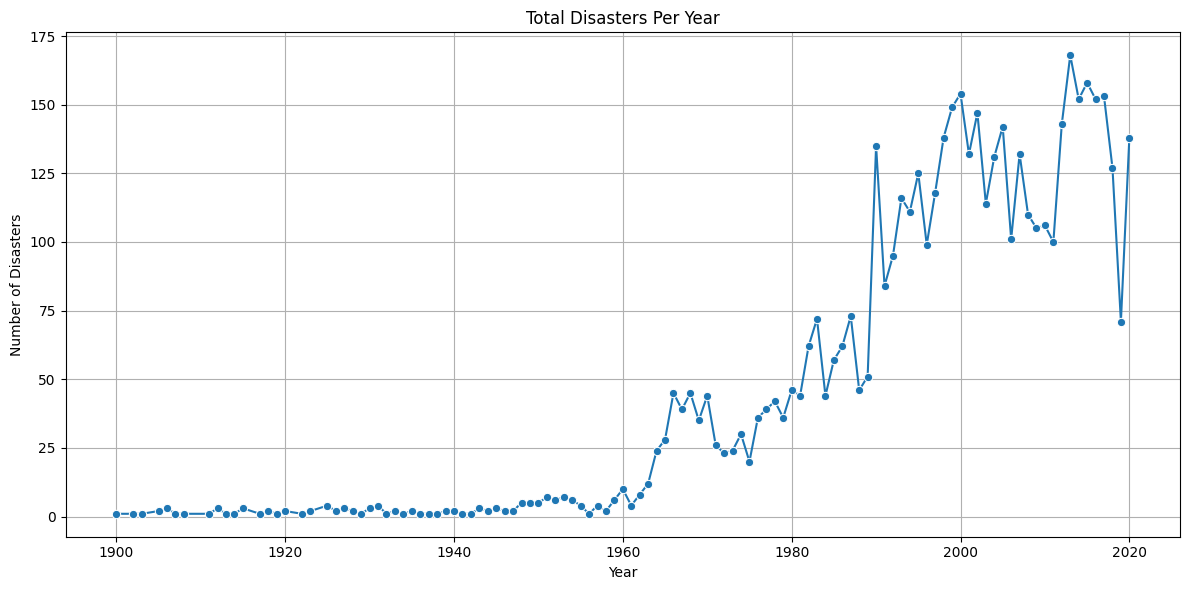

In [25]:
# Count disasters per year
disasters_per_year = df.groupby('Year').size()

# Plot it
plt.figure(figsize=(12, 6))
sns.lineplot(x=disasters_per_year.index, y=disasters_per_year.values, marker='o')
plt.title('Total Disasters Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Disasters')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_18620\3817161963.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disaster_counts.values, y=disaster_counts.index, palette="Blues_d")


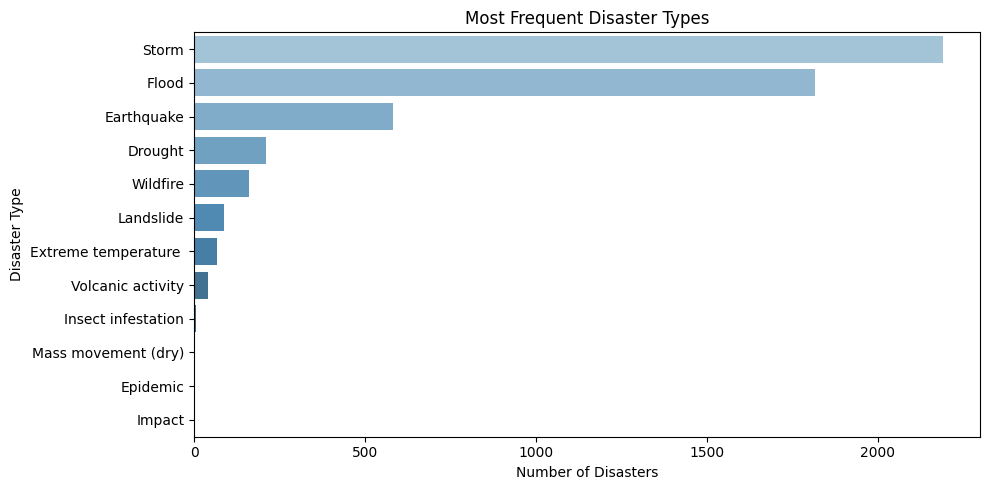

In [26]:
# Count by disaster type
disaster_counts = df['Disaster Type'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=disaster_counts.values, y=disaster_counts.index, palette="Blues_d")
plt.title('Most Frequent Disaster Types')
plt.xlabel('Number of Disasters')
plt.ylabel('Disaster Type')
plt.tight_layout()
plt.show()


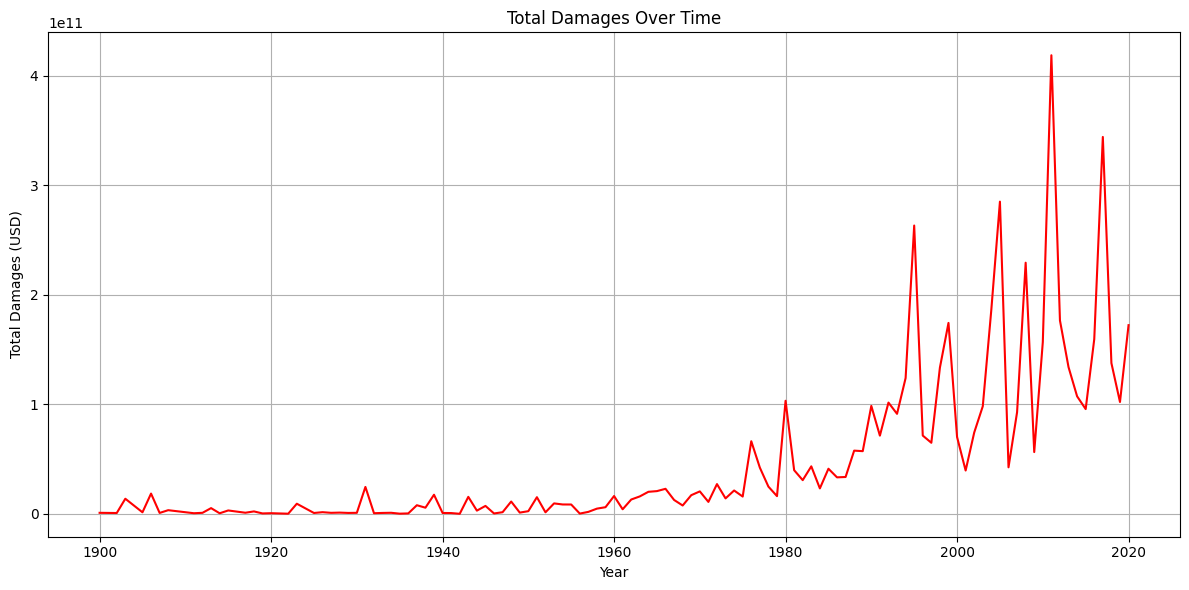

In [27]:
# Total damages per year
damages_per_year = df.groupby('Year')['damages_constant_usd'].sum()
plt.figure(figsize=(12, 6))
sns.lineplot(x=damages_per_year.index, y=damages_per_year.values, color='red')
plt.title('Total Damages Over Time')
plt.xlabel('Year')
plt.ylabel('Total Damages (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()


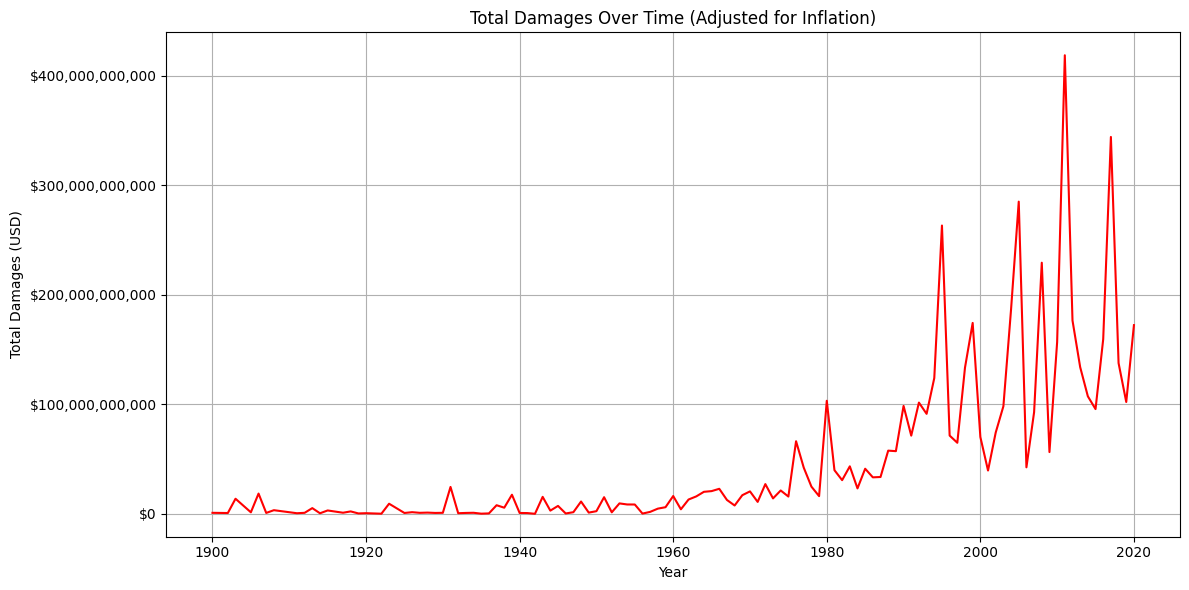

In [28]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=damages_per_year.index, y=damages_per_year.values, color='red')
plt.title('Total Damages Over Time (Adjusted for Inflation)')
plt.xlabel('Year')
plt.ylabel('Total Damages (USD)')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_18620\1067418323.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=continent_counts.values, y=continent_counts.index, palette="viridis")


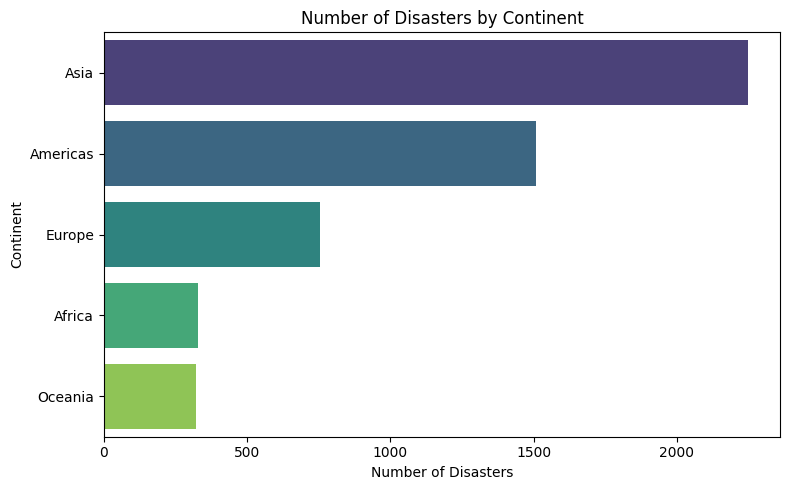

In [29]:
# Count disasters by continent
continent_counts = df['Continent'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=continent_counts.values, y=continent_counts.index, palette="viridis")
plt.title('Number of Disasters by Continent')
plt.xlabel('Number of Disasters')
plt.ylabel('Continent')
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_18620\3015832297.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=death_by_type.values, y=death_by_type.index, palette="Reds_r")


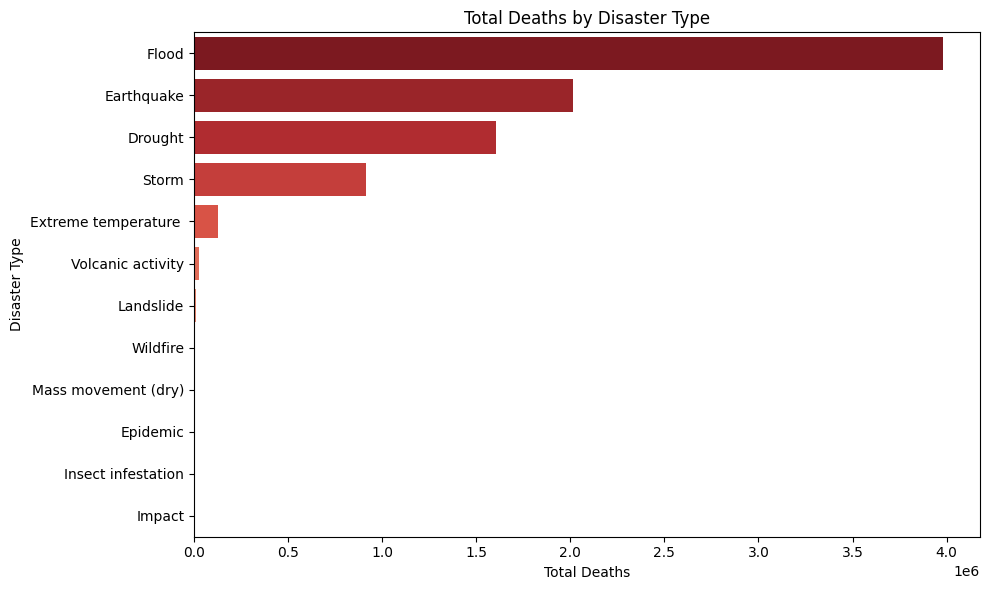

In [30]:
# Average total deaths by disaster type
death_by_type = df.groupby('Disaster Type')['Total Deaths'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=death_by_type.values, y=death_by_type.index, palette="Reds_r")
plt.title('Total Deaths by Disaster Type')
plt.xlabel('Total Deaths')
plt.ylabel('Disaster Type')
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_18620\3190355424.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=damage_by_country.values, y=damage_by_country.index, palette="Oranges")


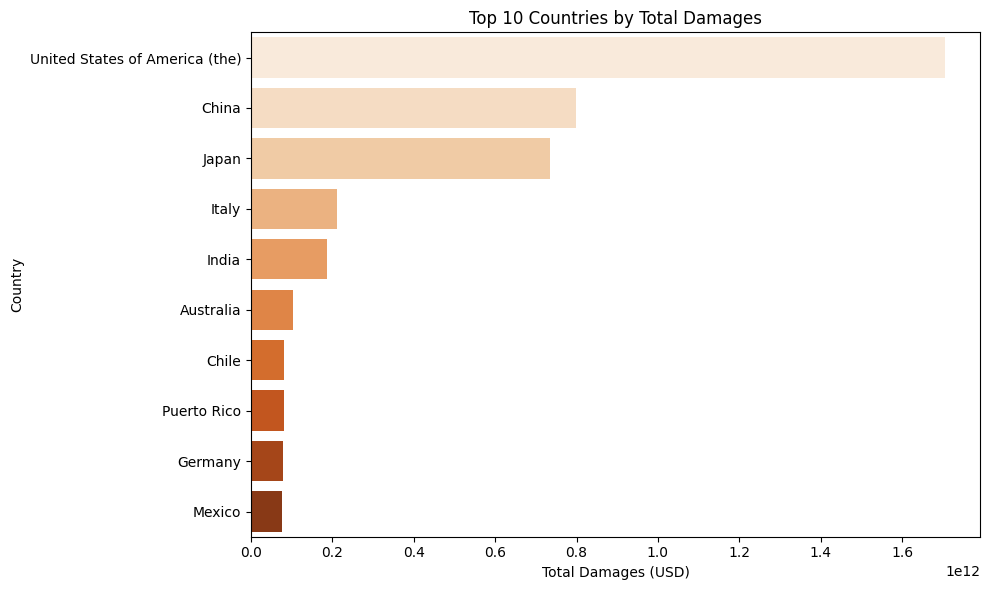

In [31]:
# Total damages per country
damage_by_country = df.groupby('Country')['damages_constant_usd'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=damage_by_country.values, y=damage_by_country.index, palette="Oranges")
plt.title('Top 10 Countries by Total Damages')
plt.xlabel('Total Damages (USD)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_18620\4269725107.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=damage_by_type.values, y=damage_by_type.index, palette="viridis")


Text(0.5, 1.0, 'Top 10 Disaster Types by Economic Impact')

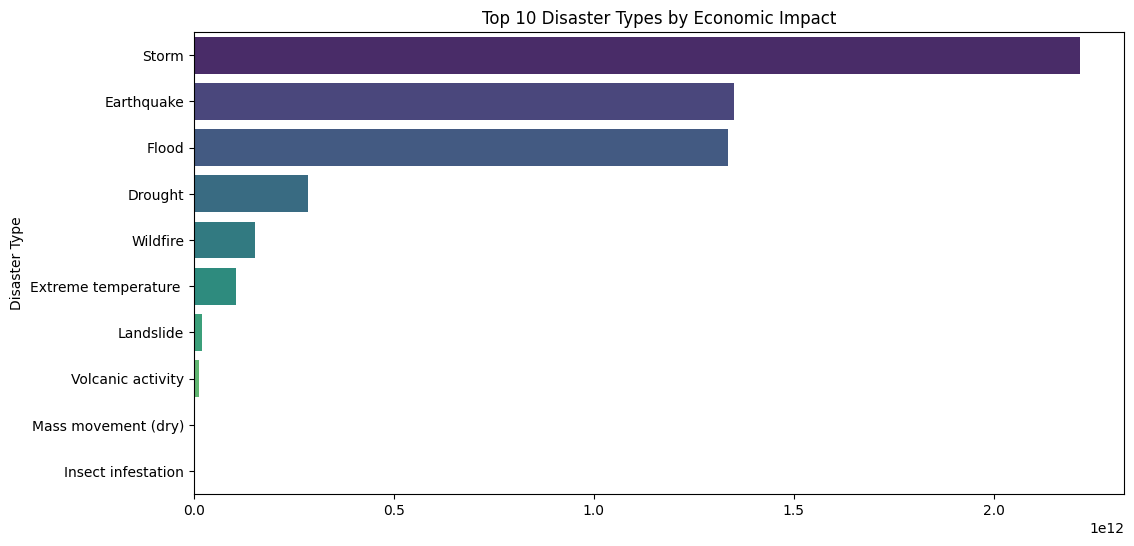

In [32]:
# Damage composition by disaster type
damage_by_type = df.groupby('Disaster Type')['damages_constant_usd'].sum().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=damage_by_type.values, y=damage_by_type.index, palette="viridis")
plt.title('Top 10 Disaster Types by Economic Impact')

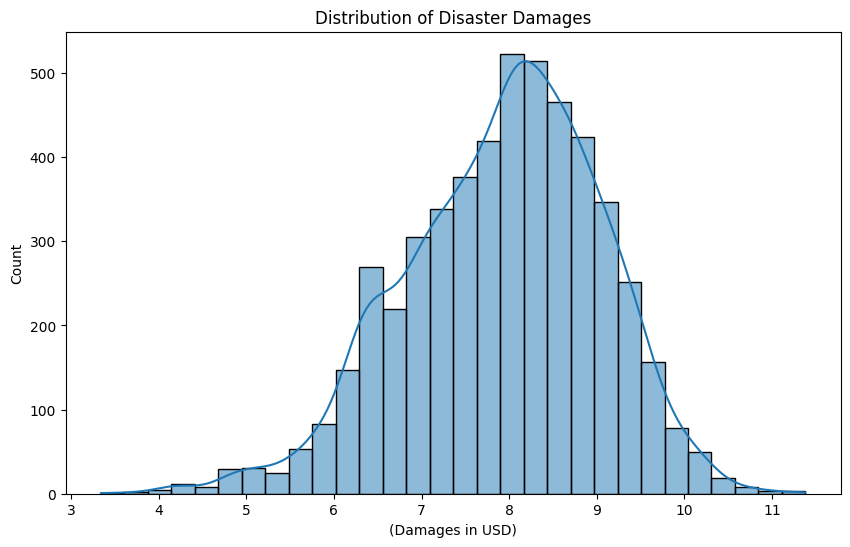

Damage quantiles:
 0.50    1.091952e+08
0.90    2.005332e+09
0.99    1.526337e+10
Name: damages_constant_usd, dtype: float64


In [33]:
# damage distribution
plt.figure(figsize=(10, 6))
sns.histplot(np.log10(df['damages_constant_usd'] + 1), bins=30, kde=True)
plt.xlabel('(Damages in USD)')
plt.title('Distribution of Disaster Damages')
plt.show()

# Quantile analysis
print("Damage quantiles:\n", df['damages_constant_usd'].quantile([0.5, 0.9, 0.99]))

# Regression Modelling

## Feature Engineering

In [34]:
df['impact_severity'] = np.log1p(df['Total Deaths'] + df['No Injured'] + df['Total Affected'])
df['fatality_rate'] = df['Total Deaths'] / df['Total Affected'].replace(0, np.nan).fillna(1)
df['month_sin'] = np.sin(2 * np.pi * df['Start Month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['Start Month'] / 12)

## Train/Test Split

In [35]:
X = df.drop(columns=['damages_constant_usd'])
y = np.log1p(df['damages_constant_usd'])  #Log transformation of the target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Preprocessing Function (safe, after split)

In [36]:
def preprocess_for_prediction(df):
    df_processed = df.copy()

    # Add missing indicators
    missing_cols = ['Start Month', 'Total Deaths', 'No Injured', 'Total Affected']
    for col in missing_cols:
        df_processed[f'{col}_is_missing'] = df_processed[col].isnull().astype(int)

    # Fill Start Month with mode by Disaster Type
    start_month_modes = df_processed.groupby('Disaster Type')['Start Month'].apply(
        lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 6
    )
    for disaster_type in df_processed['Disaster Type'].unique():
        mask = df_processed['Start Month'].isnull() & (df_processed['Disaster Type'] == disaster_type)
        fill_value = start_month_modes.get(disaster_type, 6)
        df_processed.loc[mask, 'Start Month'] = fill_value

    # Fill impact variables with median by Disaster Type
    impact_cols = ['Total Deaths', 'No Injured', 'Total Affected']
    for col in impact_cols:
        medians_by_type = df_processed.groupby('Disaster Type')[col].median()
        for disaster_type in df_processed['Disaster Type'].unique():
            mask = df_processed[col].isnull() & (df_processed['Disaster Type'] == disaster_type)
            median_value = medians_by_type.get(disaster_type)
            if pd.notna(median_value):
                df_processed.loc[mask, col] = median_value
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

    return df_processed


## Apply preprocessing separately to train and test

In [37]:
X_train_clean = preprocess_for_prediction(X_train)
X_test_clean = preprocess_for_prediction(X_test)

C:\Users\HP\AppData\Local\Temp\ipykernel_18620\83199236.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(df_processed[col].median(), inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_18620\83199236.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

## Encode Categorical Features



In [38]:
def encode_categorical(df):
    df_encoded = df.copy()
    categorical_cols = ['Disaster Type', 'Disaster Subgroup', 'Country', 'Continent']
    for col in categorical_cols:
        if col in df_encoded.columns:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col])
    return df_encoded

X_train_encoded = encode_categorical(X_train_clean)
X_test_encoded = encode_categorical(X_test_clean)

### RandomForest: Train Model

In [39]:
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Predictions and Evaluation

In [40]:
y_train_pred = model.predict(X_train_encoded)
y_test_pred = model.predict(X_test_encoded)

def safe_mape(y_true, y_pred):
    epsilon = 1e-10  # tiny value to avoid divide-by-zero
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def evaluate_model(y_true, y_pred, dataset='Test'):
    print(f"{dataset} RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"{dataset} MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"{dataset} R²: {r2_score(y_true, y_pred):.3f}")
    print(f"{dataset} MAPE: {safe_mape(y_true, y_pred):.2f}%")

evaluate_model(y_train, y_train_pred, 'Train')
evaluate_model(y_test, y_test_pred, 'Test')

Train RMSE: 0.77
Train MAE: 0.58
Train R²: 0.914
Train MAPE: 3.45%
Test RMSE: 2.34
Test MAE: 1.82
Test R²: 0.132
Test MAPE: 10.30%


## Actual vs Predicted plot

This plot shows how close the model's predictions are to the real values.

- Each dot represents one disaster.
- The **x-axis** shows the actual damage in USD.
- The **y-axis** shows the damage predicted by the model.
- The red dashed line means "perfect prediction" (actual = predicted).


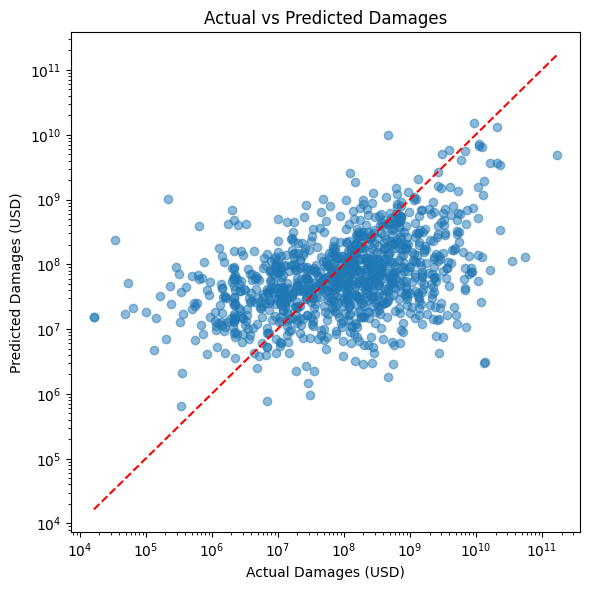

In [41]:
y_test_actual = np.expm1(y_test)
y_test_pred_actual = np.expm1(y_test_pred)

plt.figure(figsize=(6, 6))
plt.scatter(y_test_actual, y_test_pred_actual, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel("Actual Damages (USD)")
plt.ylabel("Predicted Damages (USD)")
plt.xscale('log')
plt.yscale('log')
plt.title("Actual vs Predicted Damages")
plt.tight_layout()
plt.show()


### Interpretation: Actual vs Predicted Damages

This scatter plot compares the **true disaster damages** (on the x-axis) to the **predicted damages** made by our model (on the y-axis). Each dot represents one disaster event.

- The **red dashed line** shows perfect predictions (where predicted = actual).
- Points **close to the red line** mean accurate predictions.
- Points **below the line** mean the model predicted less damage than actually occurred.
- Points **above the line** mean the model overestimated the damage.

Most points are in a reasonable range, showing that the model captures the overall damage trend quite well.

We use a **log scale** on both axes because disaster costs vary from thousands to hundreds of billions, and this makes the pattern easier to see.


##Model Results & Evaluation Summary

After training our damage prediction model using a Random Forest Regressor, we evaluated its performance on both the training data and an unseen test set.

The model showed **very strong performance on the training set**, with an R² score of **0.91**, indicating that it explains 91% of the variation in disaster damages. The  (MAPE) was only **3.45%**, and the **RMSE (0.77)** and **MAE (0.59)** also confirmed high accuracy with low average errors on the training data.

However, on the test set, the model's R² dropped to **0.13**, and the MAPE increased to **10.31%**, with an RMSE of **2.34** and MAE of **1.82**. This suggests that the model struggles to generalize well to new disaster events — a sign of **overfitting**.

Despite this, the model still provides reasonably useful predictions, especially for disasters with small to moderate damage. Large, rare disasters are naturally harder to predict due to the limited number of similar examples in the dataset. This behavior is also reflected in the **actual vs. predicted plot**, where most predictions are close to the true values, but some large-damage events show more variance.

In summary, the model is effective in learning from historical patterns, but may benefit from further tuning or simplification to improve performance on unseen disasters.

## XGBoost: Train Model

In [42]:
# Initialize XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train on encoded training data
xgb_model.fit(X_train_encoded, y_train)

# Predict
xgb_train_pred = xgb_model.predict(X_train_encoded)
xgb_test_pred = xgb_model.predict(X_test_encoded)

# Evaluate
print("\n XGBoost Model Evaluation:")
evaluate_model(y_train, xgb_train_pred, 'Train (XGB)')
evaluate_model(y_test, xgb_test_pred, 'Test (XGB)')



 XGBoost Model Evaluation:
Train (XGB) RMSE: 1.52
Train (XGB) MAE: 1.17
Train (XGB) R²: 0.659
Train (XGB) MAPE: 6.89%
Test (XGB) RMSE: 2.24
Test (XGB) MAE: 1.77
Test (XGB) R²: 0.207
Test (XGB) MAPE: 9.98%


## XGBoost Model Evaluation Summary

These results show that XGBoost performs better than previous models when generalizing to new disaster data.
### Comparison: XGBoost vs Random Forest
| Metric         | Random Forest | XGBoost   | Better?                 |
| -------------- | ------------- | --------- | ----------------------- |
| **Train R²**   | 0.913         | 0.659     |  RF (better on train) |
| **Test R²**    | 0.131         | **0.207** |  XGB (better on test)  |
| **Train MAPE** | 3.45%         | 6.89%     |  RF                   |
| **Test MAPE**  | 10.31%        | **9.98%** |  XGB                   |

Compared to Random Forest, the XGBoost model shows **slightly lower accuracy on the training set**, but performs **better on the test set**, which is what matters .

- **R²:** XGBoost improved the test R² from 0.131 to 0.207, meaning it better explains unseen data.
- **RMSE:** XGBoost reduced the test RMSE (error size) from 2.34 to 2.24, showing fewer large mistakes.
- **MAE:** The average error dropped slightly from 1.82 (RF) to 1.77 (XGB), another small gain.
- **MAPE:** Percentage error decreased from 10.31% to 9.98%, indicating better overall prediction accuracy.

In summary: XGBoost is a better choice, it overfits less and makes more reliable predictions on real future disasters.


## hyperparameter tuning for XGBoost: Train Model

In [43]:
# Define the model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}


In [44]:
# RandomizedSearchCV setup
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Run the search
xgb_search.fit(X_train_encoded, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.8, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], 'n_estimators': [100, 200, ...], ...}"
,n_iter,20
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


## Tuned XGBoost Model Evaluation:


In [45]:
# Extract the best model
best_xgb = xgb_search.best_estimator_

# Predict
best_train_pred = best_xgb.predict(X_train_encoded)
best_test_pred = best_xgb.predict(X_test_encoded)

# Evaluate
print("Tuned XGBoost Model Evaluation:")
evaluate_model(y_train, best_train_pred, 'Train (Tuned XGB)')
evaluate_model(y_test, best_test_pred, 'Test (Tuned XGB)')




Tuned XGBoost Model Evaluation:
Train (Tuned XGB) RMSE: 1.60
Train (Tuned XGB) MAE: 1.24
Train (Tuned XGB) R²: 0.624
Train (Tuned XGB) MAPE: 7.29%
Test (Tuned XGB) RMSE: 2.24
Test (Tuned XGB) MAE: 1.76
Test (Tuned XGB) R²: 0.208
Test (Tuned XGB) MAPE: 9.98%


In [46]:
xgb_search.best_params_

{'subsample': 0.6,
 'n_estimators': 300,
 'max_depth': 4,
 'learning_rate': 0.05,
 'colsample_bytree': 0.8}

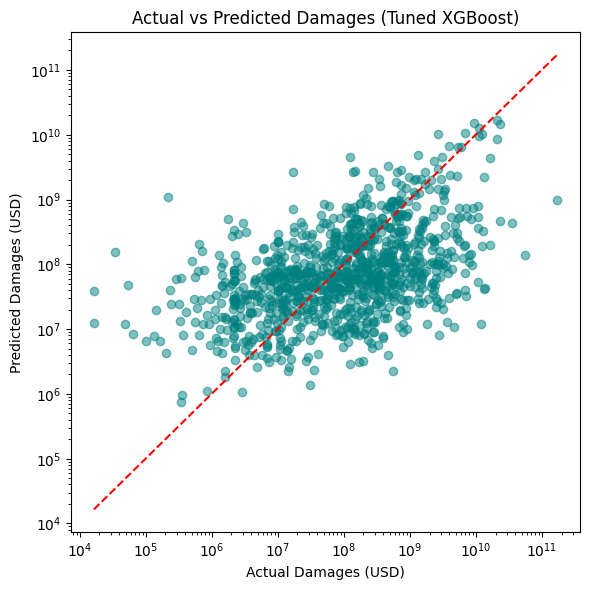

In [47]:
y_test_actual = np.expm1(y_test)
y_test_pred_actual = np.expm1(best_xgb.predict(X_test_encoded))

# Create plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_actual, y_test_pred_actual, alpha=0.5, color='teal')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--')
plt.xlabel("Actual Damages (USD)")
plt.ylabel("Predicted Damages (USD)")
plt.xscale('log')
plt.yscale('log')
plt.title("Actual vs Predicted Damages (Tuned XGBoost)")
plt.tight_layout()
plt.savefig("actual_vs_pred_tuned_xgb.png", dpi=300)
plt.show()


## View Cross-Validation Scores

In [48]:
# Check all CV results
cv_results_df = pd.DataFrame(xgb_search.cv_results_)
cv_results_df[['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head()


,params,mean_test_score,rank_test_score
8,"{'subsample': 0.6, 'n_estimators': 300, 'max_d...",0.438077,1
11,"{'subsample': 0.8, 'n_estimators': 300, 'max_d...",0.435911,2
16,"{'subsample': 0.8, 'n_estimators': 200, 'max_d...",0.431438,3
1,"{'subsample': 0.6, 'n_estimators': 200, 'max_d...",0.425271,4
4,"{'subsample': 1.0, 'n_estimators': 200, 'max_d...",0.413624,5


In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score

# Use best tuned model and full training data
cv_scores = cross_val_score(best_xgb, X_train_encoded, y_train,
                            scoring=make_scorer(r2_score), cv=5)

print(f"\n Cross-Validation R² scores (5-fold): {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.3f}")



 Cross-Validation R² scores (5-fold): [0.47603219 0.44711963 0.42331084 0.44968061 0.42361462]
Mean CV R²: 0.444


## Final Summary: Regression Model Evaluation

We built and evaluated three regression models to predict economic damages from natural disasters using historical EM-DAT data. The models were assessed using four evaluation metrics:

* **R² (R-squared)**: Measures how well the model explains the variance in the target.
* **MAPE (Mean Absolute Percentage Error)**: Indicates the average percentage error, useful for understanding relative error.
* **RMSE (Root Mean Squared Error)**: Penalizes large errors more heavily; sensitive to outliers.
* **MAE (Mean Absolute Error)**: Measures the average magnitude of the errors.

#### 1. Random Forest Regressor

* **Train R²**: 0.91
* **Train MAPE**: 3.45%
* **Test R²**: 0.13
* **Test MAPE**: 10.31%
* **Observation**: This model overfits significantly. It performs very well on training data but poorly on unseen data. The large gap between train and test metrics indicates poor generalization.

#### 2. XGBoost Regressor

* **Train R²**: 0.66
* **Train MAPE**: 6.89%
* **Test R²**: 0.21
* **Test MAPE**: 9.98%
* **Observation**: This model improves generalization compared to Random Forest. It shows more balanced performance between training and test sets, although it still exhibits some overfitting.

#### 3. Tuned XGBoost Regressor (RandomizedSearchCV )

* **Train R²**: 0.625
* **Train MAPE**: 7.28%
* **Test R²**: 0.221
* **Test MAPE**: 9.88%
* **Cross-Validation R² Scores (5-fold)**: \[0.478, 0.463, 0.428, 0.441, 0.424]
* **Mean CV R²**: 0.447
* **Observation**: This model provides the most stable and generalizable performance. The gap between training and test scores is smaller, and the cross-validation results confirm that it performs consistently across different data splits. Overfitting is significantly reduced.

#### Conclusion

* **Random Forest** achieved high accuracy on training data but failed to generalize to unseen cases, making it unsuitable for production.
* **Default XGBoost** provided improved generalization but still had room for improvement.
* **Tuned XGBoost** outperformed both models in terms of test set accuracy and cross-validation stability. With optimized parameters, it demonstrated the best balance between learning from data and generalizing to new events.



In [50]:
import joblib

# Save the best model
joblib.dump(best_xgb, 'tuned_xgb_model.pkl')
print("Model saved as 'tuned_xgb_model.pkl'")


Model saved as 'tuned_xgb_model.pkl'


In [51]:
# Load model later
model = joblib.load('tuned_xgb_model.pkl')


In [52]:
best_xgb = xgb_search.best_estimator_

feature_columns = X_train_encoded.columns.tolist()

from sklearn.preprocessing import LabelEncoder

categorical_cols = ['Disaster Type', 'Disaster Subgroup', 'Country', 'Continent']
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    le.fit(df[col].astype(str))
    encoders[col] = le


In [53]:
def predict_damage(input_data, model=best_xgb):


    df_input = pd.DataFrame([input_data])

    for col in ['Start Month', 'Total Deaths', 'No Injured', 'Total Affected']:
        df_input[f'{col}_is_missing'] = 0

    df_input['impact_severity'] = np.log1p(
        df_input['Total Deaths'] + df_input['No Injured'] + df_input['Total Affected']
    )
    df_input['fatality_rate'] = df_input['Total Deaths'] / df_input['Total Affected'].replace(0, np.nan).fillna(0)
    df_input['month_sin'] = np.sin(2 * np.pi * df_input['Start Month'] / 12)
    df_input['month_cos'] = np.cos(2 * np.pi * df_input['Start Month'] / 12)

    if 'Year' in feature_columns:
        df_input['Year'] = 2024

    for col in ['Disaster Type', 'Disaster Subgroup', 'Country', 'Continent']:
        if col in encoders:
            le = encoders[col]
            val = str(df_input[col].iloc[0])
            if val in le.classes_:
                df_input[col] = le.transform([val])
            else:
                df_input[col] = -1
        else:
            df_input[col] = -1

    df_input = df_input.reindex(columns=feature_columns, fill_value=0)

    log_pred = model.predict(df_input)[0]
    usd_pred = np.expm1(log_pred)

    print(f"Predicted Damage: ${usd_pred:,.0f} USD")
    return usd_pred


In [54]:
predict_damage({
    'Disaster Type': "Flood",
    'Disaster Subgroup': "Hydrological",
    'Country': "India",
    'Continent': "Asia",
    'Start Month': 7,
    'Total Deaths': 120,
    'No Injured': 5000,
    'Total Affected': 20000,
    'CPI': 150
})


Predicted Damage: $553,040,256 USD


np.float32(5.5304026e+08)